In [307]:
#Загрузка библиотек
import pandas as pd
from datetime import datetime
from calendar import monthrange
from operator import attrgetter
from dateutil.relativedelta import relativedelta
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display

In [308]:
#Отключение SettingWithCopyWarning.
pd.options.mode.chained_assignment = None

---

# Считывание и предобработка данных

In [309]:
df_orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 
'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [310]:
df_customers = pd.read_csv('olist_customers_dataset.csv')

In [311]:
df = df_orders.merge(df_customers, how='outer', on='customer_id')

In [312]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  object        
 9   customer_zip_code_prefix       99441 non-null  int64         
 10  customer_city                  99441 non-null  object        
 11  customer_state 

# Задание 1

###### Сколько у нас пользователей, которые совершили покупку только один раз?

Как покупки будем рассматривать заказы только со статусом processing, shipped, delivered, т.к они являются оплаченными и не отменёнными.

In [314]:
data = df \
    .query("order_status in ('processing', 'shipped', 'delivered')") \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'orders_value'}) \
    .query('orders_value == 1')
len(data)

91814

In [315]:
print(len(data), 'пользователей, которые совершили покупку только один раз')

91814 пользователей, которые совершили покупку только один раз


# Задание 2

###### Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [316]:
#Посмотрим на количество заказов с различными статусами.
df.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Заказ является доставленным, если его статус - delivered. Но заказы со статусом created, approved мы также не учитываем, так как не факт, что эти заказы будут в итоге отправлены.

In [317]:
#Посмотрим, сколько заказов фактически не было доставлено.
df.query(" order_status in ('shipped', 'processing', 'canceled', 'invoiced', 'unavailable') ").order_delivered_customer_date.isnull().sum()

2950

In [318]:
#Создадим колонку с месяцем, взятым из обещанной даты доставки.
df['month_period'] = df.order_estimated_delivery_date.dt.to_period('M')

In [319]:
#Создадим датафрейм с недоставленными заказами.
df_undelivered = df[df.order_delivered_customer_date.isnull()].query(" order_status in ('shipped', 'processing', 'canceled', 'invoiced', 'unavailable') ") \
.sort_values('month_period')
df_undelivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_period
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30,009b0127b727ab0ba422f6d9604487c7,12244,sao jose dos campos,SP,2016-09
53688,e5215415bb6f76fe3b7cb68103a0d1c0,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaT,NaT,NaT,2016-10-24,281096eb031de8c318bba51915fdd16a,62680,paracuru,CE,2016-10
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,2016-10
4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016-10
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,NaT,2016-10-25,0eb1ee9dba87f5b36b4613a65074337c,2975,sao paulo,SP,2016-10


In [320]:
#Посчитаем среднее по причинам.
orders_mean = df_undelivered \
    .groupby(['month_period','order_status'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .groupby('order_status', as_index=False) \
    .agg({'order_id': 'mean'}).round(1)
orders_mean

,order_status,order_id
0,canceled,23.8
1,invoiced,15.0
2,processing,15.8
3,shipped,48.1
4,unavailable,29.0


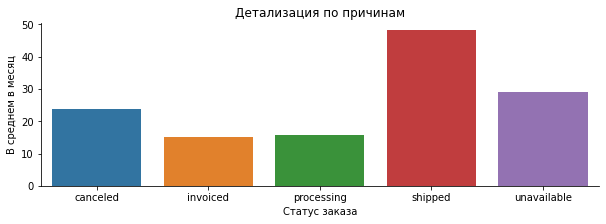

In [321]:
#Визуализируем 
plt.figure(figsize=(10,3))
ax = sns.barplot(data=orders_mean, y='order_id', x='order_status')
ax.set_title('Детализация по причинам')
ax.set_xlabel('Cтатус заказа')
ax.set_ylabel('В среднем в месяц')
sns.despine()

Основные причины недоставки заказов - отгрузка их со склада и недоступность по каким-то причинам.

In [322]:
#Посчитаем среднее количество недоставленных заказов по разным причинам.
df_undelivered_by_month = df_undelivered \
    .groupby(['month_period'], as_index=False) \
    .agg({'order_id': 'count'}) 
df_undelivered_by_month['order_id'].mean().round()

113.0

##### В среднем 113 заказов в месяц не доставляются по разным причинам.

# Задание 3

По каждому товару определить, в какой день недели товар чаще всего покупается.

In [323]:
#Считываем датасет с товарными позициями, входящими в заказы.
df_items = pd.read_csv('olist_order_items_dataset.csv')

In [324]:
#Объединяем этот датасет с двумя другими.
df = df.merge(df_items, how='left', on='order_id')

In [325]:
print(df.product_id.nunique(), 'уникальных товаров в таблице')

32951 уникальных товаров в таблице


In [326]:
#Получаем день недели из столбца с временем создания заказа.
df['order_purchase_day'] = df.order_purchase_timestamp.dt.strftime('%A')

In [327]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_period,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-08,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-09,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-12,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


Для подсчета будем использовать товары статус заказа которых processing, shipped, delivered - это заказы, которые были оплачены
и не отменены.

In [328]:
#Создадим датафрейм, где посчитаем количество заказов в каждый из дней недели.
df_purchases_by_day = df \
    .query("order_status in ('processing', 'shipped', 'delivered')") \
    .groupby(['product_id', 'order_purchase_day'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .sort_values('order_id', ascending=False) \
    .rename(columns={'order_id': 'orders_value'}) 
df_purchases_by_day.head()

,product_id,order_purchase_day,orders_value
15766,422879e10f46682990de24d770e7f83d,Wednesday,93
36178,99a4788cb24856965c36a24e339b6058,Monday,92
40679,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40675,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
40680,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


In [329]:
#Посмотрим в какие дни продукты покупаются чаще всего.
product_best_days = df_purchases_by_day.groupby('product_id')['order_purchase_day'].agg(lambda x: x.mode()).to_frame().reset_index()
product_best_days.head()

,product_id,order_purchase_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


In [330]:
print(df.product_id.nunique() - len(product_best_days), 'заказов "отпали" из-за неподходящего статуса')

337 заказов "отпали" из-за неподходящего статуса


# Задание 4

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть

Для подсчета будем использовать заказы статус которых processing, shipped, delivered - это заказы, которые были оплачены
и не отменены.

In [331]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_period,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-08,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-09,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-12,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [332]:
print(df.customer_unique_id.nunique(), 'всего уникальных пользователей')

96096 всего уникальных пользователей


In [333]:
print(df.query("order_status in ('processing', 'shipped', 'delivered')").customer_unique_id.nunique(), 'уникальных пользователей, \
совершивших покупки.')

94686 уникальных пользователей, совершивших покупки.


In [334]:
#Создадим датафрейм, где будут только совершившие покупку пользователи.
customers_purchased = df.query("order_status in ('processing', 'shipped', 'delivered')")
customers_purchased.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_period,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-08,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-09,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-12,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


In [335]:
customers_purchased['order_purchase_month_num'] = customers_purchased.order_purchase_timestamp.dt.month

In [336]:
#Получим столбец с месяцами даты создания заказа.
customers_purchased['order_purchase_month'] = customers_purchased.order_purchase_timestamp.dt.month_name()

In [337]:
# Создадим словарь с количеством дней в каждый из месяцев.
days_in_month_dict = {"January": 31, "February": 28, 
                      "March": 31, "April": 30,
                      "May": 31, "June": 30, 
                      "July": 31, "August": 31,
                      "September": 30, "October": 31,
                      "November": 30, "December": 31}
# Функция для определения високосного года.
def is_leap_year(year):
    return (year % 4 == 0) and (year % 100 != 0) or (year % 400 == 0)
# Функция для вычисления количества дней в месяце.
def days_in_month(month):
    try: 
        #attempt to get value from dictionary 
        return days_in_month_dict[month]
    except KeyError:
        #key does not exist, so we caught the error
        return None

In [338]:
# Создадим столбец с булевым значением для определения високосного года.
customers_purchased['leap_year'] = customers_purchased['order_purchase_timestamp'].dt.year.apply(is_leap_year)

In [339]:
# Вычислим количество дней в каждый из месяцев.
customers_purchased['days_in_month'] = customers_purchased.month_period.dt.days_in_month

In [340]:
# Заполним пропуски в столбце с количеством дней нулями, чтобы выполнился цикл.
customers_purchased['days_in_month'] = customers_purchased['days_in_month'].fillna(0)

In [341]:
# Заменим количество дней в феврале на 29 в високосный год. (Несмотря на то что данных о феврале в високосный год нет.)
for i in customers_purchased['days_in_month']:
    if customers_purchased['leap_year'][i] == True and customers_purchased['order_purchase_month'][i] == "February":
        customers_purchased['days_in_month'][i].replace(28, 29)

In [342]:
# Посчитаем количество недель в каждом месяце.
customers_purchased['weeks_value'] = customers_purchased['days_in_month'] / 7

In [343]:
customers_purchased.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,seller_id,shipping_limit_date,price,freight_value,order_purchase_day,order_purchase_month_num,order_purchase_month,leap_year,days_in_month,weeks_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday,10,October,False,31,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday,7,July,False,31,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday,8,August,False,30,4.285714
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday,11,November,False,31,4.428571
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday,2,February,False,28,4.000000


In [344]:
# Создадим датафрейм, где посчитаем количество заказов на пользователя по периодам.
customers = customers_purchased \
    .groupby(['customer_unique_id', 'month_period', 'weeks_value'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'purchases'}) \
    .sort_values('purchases', ascending=False)
customers.head()

,customer_unique_id,month_period,weeks_value,purchases
26210,4546caea018ad8c692964e3382debd19,2017-07,4.428571,21
74114,c402f431464c72e27330a67f7b94d4fb,2018-03,4.428571,20
39958,698e1cf81d01a3d389d96145f7fa6df8,2017-09,4.285714,20
75722,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,18
5826,0f5ac8d5c31de21d2f25e24be15bbffb,2017-12,4.428571,18


In [345]:
#Посчитаем количество покупок в неделю.
customers['purchases_per_week'] = round(customers.purchases / customers.weeks_value, 2)

In [346]:
#Отберём нужные столбцы.
customers = customers[['customer_unique_id', 'month_period', 'purchases_per_week']]

In [347]:
#Отсекаем данные первого и последнего периодов, т.к они неполные.
customers = customers.query(" '2016-10' < month_period < '2018-10' ").sort_values('purchases_per_week', ascending=False)
customers.head()

,customer_unique_id,month_period,purchases_per_week
26210,4546caea018ad8c692964e3382debd19,2017-07,4.74
39958,698e1cf81d01a3d389d96145f7fa6df8,2017-09,4.67
74114,c402f431464c72e27330a67f7b94d4fb,2018-03,4.52
75722,c8460e4251689ba205045f3ea17884a1,2018-08,4.06
5826,0f5ac8d5c31de21d2f25e24be15bbffb,2017-12,4.06


In [348]:
#Посчитаем среднее количество покупок в неделю по месяцам
customers \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'purchases_per_week': 'mean'}) \
    .sort_values('purchases_per_week', ascending=False)

,customer_unique_id,purchases_per_week
25680,4546caea018ad8c692964e3382debd19,4.74
39139,698e1cf81d01a3d389d96145f7fa6df8,4.67
72555,c402f431464c72e27330a67f7b94d4fb,4.52
5699,0f5ac8d5c31de21d2f25e24be15bbffb,4.06
6711,11f97da02237a49c8e783dfda6f50e8e,3.39
...,...,...
34415,5ca67c5cbf18b91e7bd892e915516425,0.23
34414,5ca59bab56181fa331bf3c0689f326d6,0.23
34413,5ca4f0e4b391b8c8dddfd7585e34cfec,0.23
34412,5ca4a66089082ffa052945c696b13dcf,0.23


# Задание 5.

Выполните когортный анализ пользователей. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

Retention – показатель удержания пользователей. Иными словами – отражает то, сколько пользователей возвращаются в продукт спустя
заданное время. 

Обычно день начала использования сервиса называется Day 0 – момент, когда юзер впервые воспользовался продуктом. N-Day Retention
показывает, сколько процентов пользователей, начавших пользоваться продуктом в день 0, вернулись и продолжили использовать 
продукт N дней спустя.  

In [349]:
print(df.order_approved_at.isnull().sum(), 'заказов без времени подтверждения оплаты заказа')

161 заказов без времени подтверждения оплаты заказа


In [350]:
# Не будем учитывать такие заказы, поэтому удалим их.
df1 = df.dropna(axis='index', how='any', subset=['order_approved_at'])

In [351]:
df1

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,month_period,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-08,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-09,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-12,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-03,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,Tuesday
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-09,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,Sunday
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-02,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-02,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday


In [352]:
#Отберем только нужные столбцы.
df1 = df1[['customer_unique_id', 'month_period']]
df1.head(3)

,customer_unique_id,month_period
0,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,af07308b275d755c9edb36a90c618231,2018-08
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-09


In [353]:
#Создадим столбец с датой первой покупки.
df1.loc[:,'cohort'] = df1.groupby('customer_unique_id')['month_period'].transform('min')
df1.head(3)

,customer_unique_id,month_period,cohort
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-08,2018-08
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-09,2018-09


In [354]:
#Создадим столбец с количеством месяцев от первой покупки.
df1['period'] = (df1.month_period - df1.cohort).apply(attrgetter("n"))
df1.head(3)

,customer_unique_id,month_period,cohort,period
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,1
1,af07308b275d755c9edb36a90c618231,2018-08,2018-08,0
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-09,2018-09,0


In [355]:
#Посчитаем количество уникальных покупателей.
df1 = df1.groupby(['cohort','period'])['customer_unique_id'].nunique().reset_index()
df1.head(3)

,cohort,period,customer_unique_id
0,2016-09,0,1
1,2016-10,0,5
2,2016-10,12,1


In [356]:
#Создадим сводную таблицу.
df1_pivot = df1.pivot(index='cohort', columns='period', values='customer_unique_id')

In [357]:
# Подсчет общего количества пользователей в каждой когорте.
df1_sz = df1_pivot.iloc[:, 0]

# Разделение значений сводной таблицы на общее количество клиентов в каждой когорте и умножение на 100 для получения процентного выражения.
retention_rate = (df1_pivot.divide(df1_sz, axis=0) * 100).round(2)

# В задании требуется в промежутке от января по декабрь (полный год) определить кагорту с самым высоким Retention за третий месяц.
# Так как ни в 2016, ни в 2018 нет полных данных за год, оставляем только 2017.
retention_rate = retention_rate.loc[pd.Period('2017-01', 'M'):pd.Period('2017-12', 'M')]

In [358]:
retention_rate

period,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,21
cohort,,,,,,,,,,,,,,,,,,,,,
2017-01,100.0,33.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02,100.0,1.68,NaN,1.01,0.34,NaN,0.67,NaN,NaN,NaN,...,NaN,0.67,NaN,NaN,NaN,NaN,0.34,NaN,0.34,NaN
2017-03,100.0,0.51,0.18,0.40,0.18,0.22,0.26,0.15,0.07,0.26,...,0.37,0.26,0.18,0.18,0.04,0.11,0.15,NaN,NaN,NaN
2017-04,100.0,1.14,0.32,0.46,0.23,0.05,0.23,0.36,0.18,0.23,...,0.14,0.18,0.18,0.14,0.27,0.23,0.09,NaN,NaN,NaN
2017-05,100.0,0.78,0.41,0.27,0.30,0.27,0.27,0.47,0.14,0.24,...,0.14,0.14,0.03,0.14,0.20,0.10,NaN,NaN,NaN,NaN
2017-06,100.0,0.65,0.40,0.40,0.40,0.37,0.34,0.20,0.20,0.34,...,0.28,0.20,0.17,0.28,0.06,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,0.93,0.50,0.40,0.25,0.25,0.34,0.28,0.19,0.28,...,0.22,0.31,0.31,0.03,0.03,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.62,0.45,0.24,0.31,0.19,0.31,0.19,0.21,0.26,...,0.28,0.14,0.12,0.02,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.89,0.28,0.38,0.52,0.35,0.28,0.28,0.26,0.14,...,0.26,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [359]:
# Форматируем стиль.
ur_style = (retention_rate
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2f}%", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

/opt/tljh/user/lib/python3.7/site-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/tljh/user/lib/python3.7/site-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21
cohort,,,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,33.33%,,,,,,,,,,,,,,,,,,,
2017-02,100.00%,1.68%,,1.01%,0.34%,,0.67%,,,,0.67%,,0.67%,,,,,0.34%,,0.34%,
2017-03,100.00%,0.51%,0.18%,0.40%,0.18%,0.22%,0.26%,0.15%,0.07%,0.26%,0.15%,0.37%,0.26%,0.18%,0.18%,0.04%,0.11%,0.15%,,,
2017-04,100.00%,1.14%,0.32%,0.46%,0.23%,0.05%,0.23%,0.36%,0.18%,0.23%,0.23%,0.14%,0.18%,0.18%,0.14%,0.27%,0.23%,0.09%,,,
2017-05,100.00%,0.78%,0.41%,0.27%,0.30%,0.27%,0.27%,0.47%,0.14%,0.24%,0.37%,0.14%,0.14%,0.03%,0.14%,0.20%,0.10%,,,,
2017-06,100.00%,0.65%,0.40%,0.40%,0.40%,0.37%,0.34%,0.20%,0.20%,0.34%,0.17%,0.28%,0.20%,0.17%,0.28%,0.06%,,,,,
2017-07,100.00%,0.93%,0.50%,0.40%,0.25%,0.25%,0.34%,0.28%,0.19%,0.28%,0.31%,0.22%,0.31%,0.31%,0.03%,0.03%,,,,,
2017-08,100.00%,0.62%,0.45%,0.24%,0.31%,0.19%,0.31%,0.19%,0.21%,0.26%,0.14%,0.28%,0.14%,0.12%,0.02%,,,,,,
2017-09,100.00%,0.89%,0.28%,0.38%,0.52%,0.35%,0.28%,0.28%,0.26%,0.14%,0.26%,0.26%,0.02%,,,,,,,,


In [384]:
# Найдем когорту с самым высоким retention на 3й месяц.
round(retention_rate.div(retention_rate.iloc[:,0], axis = 0).mul(100), 2)[3].idxmax()

Period('2017-02', 'M')

#### Самый высокий retention на 3й месяц в когорте - 2017-07, и это всего 0,5%. Из проделанного исследования можно увидеть, что удержание пользователей очень низкое, стоит поработать над маркетингом.

# Задание 6

#### RFM сегментация пользователей.

In [361]:
# recency frequency monetary

# r - как давно была первая покупка ( чем более недавно, тем лучше );
# f - как часто покупал ( чем чаще, тем лучше );
# m - сколько денег потратил ( чем больше, тем лучше );

# Сегментация клиента: claster = 'r' + 'f' + 'm' (r=1 + f=1 + m=1 => frm = 111) 

In [362]:
# Отбираем нужные нам колонки, для дальнейшей склейки таблиц.

s_custom = df_customers[['customer_id', 'customer_unique_id']]
s_custom.head(3)

,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e


In [363]:
# Отбираем нужные нам колонки, для дальнейшей склейки таблиц.
# Агрегируем данные и находим общую стоимоть заказа.

s_items = df_items[['order_id', 'price']]
s_items = s_items.groupby('order_id',as_index=False).agg({'price':'sum'})
s_items.head(3)

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.9
1,00018f77f2f0320c557190d7a144bdd3,239.9
2,000229ec398224ef6ca0657da4fc703e,199.0


In [364]:
# Отбираем только те заказы, котрые по итогу были доставлены клиенту, для корректного проведения анализа.
# Оставляем только те колонки, которые потребуются нам для дальнейшей склейки таблиц.

s_orders = df_orders.query('order_status == "delivered"')[['order_id', 'customer_id', 'order_purchase_timestamp']]
s_orders.head(3)

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49


In [365]:
# Склеиваем таблицы по колонке общей колонке order_id
# Для корректного представления данных, взял за основу таблицу s_orders, которые уже были отфильтрованы по статусу заказа.
# Выбираю метод left join что бы примкнуть к основой таблице колонку price

prom = s_orders.merge(s_items, how='left', on = 'order_id')
prom.head(3)

,order_id,customer_id,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,159.90


In [366]:
# В данном случае делаю тоже самое, только за основу беру новую таблицу prom, в которой лежат объединённые данные,
# отсортированные по статусу заказа.

proc = prom.merge(s_custom, how = 'left', on = 'customer_id')

In [367]:
# Исключаю из списка колонок колонку "customer_id", так как она нам не актуальна.
# Устанавливаю порядок колонок в удобном для себя формате.

proc = proc[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'price']]
proc.head(3)

# Теперь у нас готовая таблица, состоящая из уникального id клиента, номера заказа, даты покупки и суммы корзины.
# Таблица содержит в себе покупки, которые билы по итогу реализованы.

,customer_unique_id,order_id,order_purchase_timestamp,price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90


In [368]:
# Проверяю на количетсво пропущенных значений.

proc.isna().sum()

# Пропусков нигде не обнаружено.

customer_unique_id          0
order_id                    0
order_purchase_timestamp    0
price                       0
dtype: int64

In [369]:
# Избавимся от ненужной информации врмени, оставив в колонке только дату

proc.order_purchase_timestamp = proc.order_purchase_timestamp.dt.date

In [370]:
print('Заказы от {} до {}'.format(proc.order_purchase_timestamp.min(),
                                    proc.order_purchase_timestamp.max()))

Заказы от 2016-09-15 до 2018-08-29


In [371]:
proc.rename(columns={'order_purchase_timestamp':'order_date'}, inplace=True)

Я смоделирую анализ, установив NOW дату на один день после последней покупки. Эта дата будет использоваться в качестве ориентира для расчета Recency балла.

In [372]:
now = proc.order_date.max() + timedelta(days=1)
print(f'Симуляционная дата анализа - {now}')

Симуляционная дата анализа - 2018-08-30


In [373]:
# Группируем данные по id клиента и считаем сумму всех покупок, количество покупок и кол-во дней с момента последней покупки.

rfm = proc.groupby('customer_unique_id')\
          .agg({'price':'sum', 'order_id':'count','order_date': lambda x: (now - x.max()).days})\
          .reset_index()

In [374]:
rfm.rename(columns={'customer_unique_id':'unique_id','order_id':'frequency', 'order_date':'recency', 'price':'monetary'}, inplace=True)

In [375]:
rfm = rfm[['unique_id','recency','frequency','monetary']]
rfm.head(3)

,unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9
2,0000f46a3911fa3c0805444483337064,538,1,69.0


#### RFM анализ будем проводить, исходя из данных за последний год (365 дней).

Метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

In [376]:
rfm = rfm.query('recency <= 365')
rfm.head(3)

,unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99


In [383]:
# 1. Чем меньше значение в колонке recency, тем выше балл. Следовательно для этого создаём лейбел,
# где список будет содержать 5 баллов в порядке убывания

# 2. В остальных колонках наоборот, чем больше значение, тем больше балл.
# Поэтому мы и создадим список в порядке возрастания.

# 3. С помощью метода cut делим значения на равные части и присваиваем лейблы каждой колонке.


r_lable = range(5, 0, -1) 
f_lable = range(1, 6)
m_lable = range(1, 6)
r_group = pd.cut(rfm.recency, bins = 5, labels=r_lable)
f_group = pd.cut(rfm.frequency, bins = 5, labels=f_lable)
m_group = pd.cut(rfm.monetary, bins = 5, labels=m_lable)

In [378]:
# Присваиваем новым колонкам значения.

rfm.loc[:,'R'] = r_group
rfm.loc[:,'F'] = f_group
rfm.loc[:,'M'] = m_group

In [379]:
# Для сложения чисел необходимо преобразовать их в формат строки.

rfm.loc[:, 'RFM'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

In [380]:
# С помощью regexp делим на сегменты значения.
# Создаем новую колонку, с сегментами

segt_map = {
    r'[1-2][1-2]': 'бездействие',
    r'[1-2][3-4]': 'в зоне риска',
    r'[1-2]5': 'нельзя отпускать',
    r'3[1-2]': 'засыпающий',
    r'33': 'требуют внимания',
    r'[3-4][4-5]': 'постоянный клиент',
    r'41': 'перспективные клиенты',
    r'51': 'новый клиент',
    r'[4-5][2-3]': 'потенциальный лоялист',
    r'5[4-5]': 'чемпионы'
}


rfm.loc[:, 'segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm.loc[:, 'segment'] = rfm['segment'].replace(segt_map, regex=True)

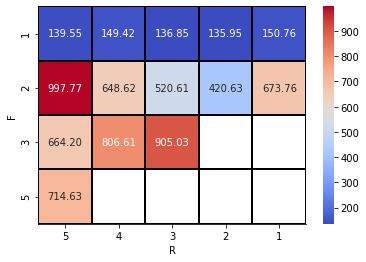

In [381]:
# Строим тепловую карту и видим среднюю выручку на каждый сегмент.

table = rfm.pivot_table(index='F', columns='R', values='monetary', aggfunc='mean')
sns.heatmap(table, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='coolwarm')
sns.despine()

In [382]:
# Для наглядности результатов, сгруппируем данные по сегментам и посчитаем средние показатели и количество человек в каждом сегменте.

level_agg = rfm.groupby('segment').agg({'recency':'mean', 'frequency':'mean', 'monetary':['mean', 'count']}).round(1)
level_agg.columns = level_agg.columns.droplevel()
level_agg.columns = ['days_mean', 'purch_mean', 'revenue_mean', 'customer']
level_agg.reset_index(inplace=True)
level_agg.loc[:,'customer %'] = np.round((level_agg['customer'] / level_agg['customer'].sum())*100, 3)
level_agg

,segment,days_mean,purch_mean,revenue_mean,customer,customer %
0,бездействие,285.1,1.0,141.7,25870,35.658
1,засыпающий,182.7,1.0,137.1,16228,22.368
2,новый клиент,37.0,1.0,139.6,14990,20.662
3,перспективные клиенты,111.5,1.0,149.4,15435,21.275
4,потенциальный лоялист,65.7,4.6,815.9,24,0.033
5,требуют внимания,190.5,8.0,905.0,2,0.003
6,чемпионы,10.0,15.0,714.6,1,0.001


#### Выводы.
#### Плюсы:
#### - Есть перспективы работать над клиентами сегмента "перспективные" и "новый клиент", которые составляют порядка 40 %, а так же привлечь их "специальными предложениями" для поднятия показателя средней выручки.
#### Минусы:
#### - На основе полученных данных можно предположить, что более 55% клиентов не удерживаются компанией и требуют серьезных механизмов, позволяющих замотивировать пользователей к более высокой активности. Рекомендуется разработать систему лоляльности для отточных клиентов.
#### - Низкий процент "костяк" компании ( < 1% ).
#### - Низкое количество покупок на одного клиента.
#### - Основная масса клиентов купили товар однажды. 